## **OPTIONS PRICING**

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

A derivative is a financial instrument whose value is derived from that of another asset or index. The most common are forwards, futures, options and swaps.

The main uses of derivatives are risk hedging, arbitrage (i.e. buying a product in one market and selling it in another) and speculation.

[Teoria libro ...]

In this case, we will only consider European options because, unlike American options, they can only be exercised at maturity.

In [2]:
'''Parameters'''

S = 105              
K = 105                 
T = 1                   
r = 0.05                
sigma = 0.2    
         
N = 1000 

# MODELS

## 1. Black-Scholes

This method is based on the idea that the price of the asset (underlying), on which the derivative is based, follows a geometric Brownian motion, meaning that it moves randomly but with a certain trend and volatility.

NOTE: This method does not consider the dividends --> if the underlying pays dividends, the model will overestimates the Call price and underestimates the Put price. In this case, we'll use the Black-Scholes-Merton method. \
Furthermore, an important ‘weakness’ of the model is the assumption that the distribution is normal (GBM), and volatility constant (in real markets, price changes show fat tails and non-constant volatility). Although there are more accurate models (Fractal Cascade), BS remains one of the easiest, most practical and quickest models to implement.

$$\frac{1}{2}\sigma^2S^2 \frac{\partial ^ 2 V}{\partial S^2} + rS  \frac{\partial V}{\partial S}  + \frac{\partial V}{\partial t} - rV = 0$$

•	 $V(S,t)$  → option price

•	 $S$  → underlying price

•	 $\sigma$  → underlying volatility (**constant**)

•	 $r$  → risk-free rate (**constant**)

•	 $t$  → time to option expiry

•	 $K$  → strike price (used later, the price we buy the asset)

The underlying follows a GBM: 
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

So:

•	The term $\frac{\partial^2 V}{\partial S^2}$ describes how the value of the option changes with respect to the price curvature of the underlying S. This term is associated with the volatility $\sigma^2$, which is a measure of price variability. It is crucial for modelling the risk associated with the underlying.

•	The term $rS \frac{\partial V}{\partial S}$
represents the contribution from the linear change in the value of the option relative to the price of the underlying asset, related to the opportunity cost of holding (or replicating) the asset.

•	The term $\frac{\partial V}{\partial t}$
indicates how the value of the option changes over time. This is related to the phenomenon of time decay, i.e. the loss of value of the option as expiry approaches.

•	The term $-rV$
takes into account the discounted present value of the option, based on the risk-free interest rate r.

An analytical solution (for European options only, that can only be exercised at expiration) is derived from this equation, which allows the value of a call or put option to be calculated directly:

$$
\begin{align*}
&C = S_0 N(d_1) - K e^{-rT} N(d_2) \\

&P = K e^{-rT} N(-d_2) - S_0 N(-d_1)
\end{align*}
$$

with

$$
d_1 = \frac{\ln(S_0 / K) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}; \quad d_2 = d_1 - \sigma \sqrt{T}
$$


$e^{-rT}$ is the discount rate (Net Present Value), so the discount factor that takes into account the time value of money under a risk-free interest rate $r$. \
$d_1$ is a parameter that measures the probability of the option to expire in-the-money ($S>K$). For example, if $d_1 = 0.5$ , this means that the probability of the option expiring in-the-money is about 69.2%, because $N(0.5) \approx 0.692$ . It measures how much the asset price today ($S_0$) is above or below the strike price ($K$). 

•	 N($d_1$)  → Risk-neutral probability of the asset price reaching an in-the-money value.

•	 N($d_2$)  → Risk-neutral probability that the underlying will exceed the strike at expiry.

(in the BSM model, we'll add a discount rate also for $d_1$)

In [3]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

**Greeks** are the partial derivatives with respect to the variables on which the option price depends. \
They depend on $d_1$ and $d_2$. \
Here we calculate them just for the call options.

•      Delta $\Delta =  \frac{\partial C}{\partial S} \implies \Delta_{\text{call}} = N(d_1) $. It is the slope. If the Delta of the call is 0.6, the trader can hedge his exposure by buying 0.6 shares for each call sold. So, the Delta changes over time (Delta Hedging --> building a portfolio neutral to Delta).

•      Theta $\Theta =   \frac{\partial C}{\partial T}  \implies \Theta_{\text{call}} = -\frac{S N{\prime}(d_1) \sigma}{2\sqrt{T}} - r K e^{-rT} N(d_2)$. The more negative the value, the faster the option loses value over time.

•      Gamma $\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{N{\prime}(d_1)}{S \sigma \sqrt{T}}$. It reaches the max when the options are at-the-money (ATM: $S=K$).

The relationship between these three (without dividends) is $\Theta + rS\Delta + 1/2 \sigma^2 S^2 \Gamma = r\Pi$, where $\Pi$ is the value of the portfolio.

•      Vega $ \nu  =  \frac{\partial C}{\partial \sigma} = S N{\prime}(d_1) \sqrt{T}$

•      Rho  $\rho = \frac{\partial C}{\partial r} \implies \rho_{\text{call}} = K T e^{-rT} N(d_2)$


In [ ]:
def greeks(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + (sigma**2 / 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    Delta = norm.cdf(d1)

    Gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))

    Theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)

    Vega = S * norm.pdf(d1) * np.sqrt(T)

    Rho = K * T * np.exp(-r * T) * norm.cdf(d2)

    return Delta, Gamma, Theta, Vega, Rho

In [5]:
call_price_bs = black_scholes(S, K, T, r, sigma, option_type="call")
put_price_bs = black_scholes(S, K, T, r, sigma, option_type="put")

print(f"Call price (Black-Scholes): {call_price_bs:.2f}")
print(f"Put price (Black-Scholes): {put_price_bs:.2f}")

Call price (Black-Scholes): 10.97
Put price (Black-Scholes): 5.85


In [6]:
Delta, Gamma, Theta, Vega, Rho = greeks(S, K, T, r, sigma, "call")

print(f"Delta: {Delta:.4f}")
print(f"Gamma: {Gamma:.4f}")
print(f"Theta: {Theta:.4f}")
print(f"Vega: {Vega:.4f}")
print(f"Rho: {Rho:.4f}")

Delta: 0.6368
Gamma: 0.0179
Theta: -6.7347
Vega: 39.4002
Rho: 55.8941


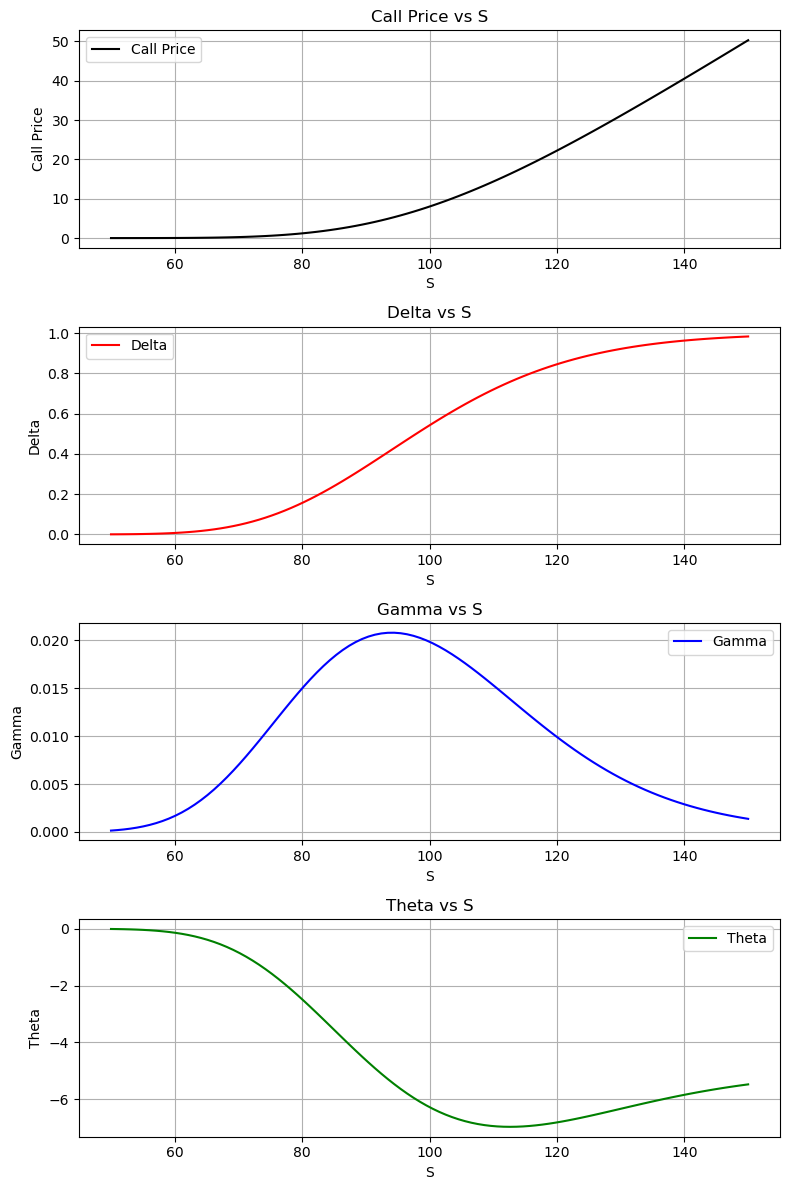

In [11]:
S_range = np.linspace(50, 150, 100)  

deltas = [greeks(S, K, T, r, sigma, "call")[0] for S in S_range]
gammas = [greeks(S, K, T, r, sigma, "call")[1] for S in S_range]
thetas = [greeks(S, K, T, r, sigma, "call")[2] for S in S_range]
call_prices = [black_scholes(S, K, T, r, sigma, "call") for S in S_range]


fig, axes = plt.subplots(4, 1, figsize=(8, 12))

# Call Price vs S 
axes[0].plot(S_range, call_prices, label="Call Price", color='black')
axes[0].set_xlabel("S")
axes[0].set_ylabel("Call Price")
axes[0].set_title("Call Price vs S")
axes[0].legend()
axes[0].grid()

# Delta vs S
axes[1].plot(S_range, deltas, label="Delta", color='red')
axes[1].set_xlabel("S")
axes[1].set_ylabel("Delta")
axes[1].set_title("Delta vs S")
axes[1].legend()
axes[1].grid()

# Gamma vs S
axes[2].plot(S_range, gammas, label="Gamma", color='blue')
axes[2].set_xlabel("S")
axes[2].set_ylabel("Gamma")
axes[2].set_title("Gamma vs S")
axes[2].legend()
axes[2].grid()

# Theta vs S
axes[3].plot(S_range, thetas, label="Theta", color='green')
axes[3].set_xlabel("S")
axes[3].set_ylabel("Theta")
axes[3].set_title("Theta vs S")
axes[3].legend()
axes[3].grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## 2. Monte Carlo

This model uses stochastic simulations to estimate the price of an option. Unlike the Black-Scholes formula, which provides a closed solution for European options, Monte Carlo is more flexible (and can be used for any type of option) but slower than BS. It can also include path-dependent options, and does not consider american options.

The basic idea is to simulate multiple possible scenarios for the price of the underlying asset until expiry, then calculate the expected discounted value of the payoff. 



The price of the asset $S_t$ is modelled with the Geometric Brownian Motion (a solution of the previous equation, obtained by applying Ito's Lemma):

$$


S_T = S_0 e^{(r - \frac{1}{2} \sigma^2)T + \sigma \sqrt{T} Z}


$$

where $T$ is the maturity,  $Z \sim N(0,1)$  is a standard normal random variable (random walk).

Once we get the simulated prices $S_T$, we calculate the payoff:

•	Call Option: $\text{Payoff} = \max(S_T - K, 0)$

•	Put Option: $\text{Payoff} = \max(K - S_T, 0)$


To obtain the value of the option, we calculate the average of the simulated payoffs and discount them to the present time using the risk-free rate:


$$C = e^{-rT} \cdot \frac{1}{N} \sum_{i=1}^{N} \text{Payoff}_i$$

where $N$ is the number of simulations.


In [51]:
def montecarlo_pricing(S, K, T, r, sigma, N, option_type="call"):
    dt = T  #N(0,1)
    Z = np.random.randn(N)
    ST = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - ST, 0)

    return np.exp(-r * T) * np.mean(payoff) 

In [67]:
call_price_mc = montecarlo_pricing(S, K, T, r, sigma, N, option_type="call")
put_price_mc = montecarlo_pricing(S, K, T, r, sigma, N, option_type="put")

print(f"Call Price (Monte Carlo): {call_price_mc:.2f}")
print(f"Put Price (Monte Carlo): {put_price_mc:.2f}")

Call Price (Monte Carlo): 11.05
Put Price (Monte Carlo): 6.38


## 3. Binomial Tree

Unlike BS, which gives a closed-form solution, this method model the evolution of an asset’s price in discrete time steps. It is also suitable for american options, since it allows for early exercise at any point in time. It can also handle larger complexity due to the varying volatility!

The main idea is to break down the time to expiration $T$ into small discrete steps $\Delta t$, at which $S$ can go up (with a $p$ probability) or down (with a $1-p$ probability) by a ceratin percentage, creating a binary tree. \
The model becomes more accurate as the number of time steps increases, eventually converging with the Black-Scholes model in the limit of infinite steps. This is obviously the slower model.

So we'll have

•	 up-factor → how much the price increases per step: 
$u = e^{\sigma \sqrt{\Delta t}}$


•	 down-factor → how much the price decreases per step: $
d = \frac{1}{u} = e^{-\sigma \sqrt{\Delta t}}
$

•	 risk-neutral probability of the up-move: $
p = \frac{e^{r \Delta t} - d}{u - d}
$

We start with the initial price $S_0$, at each step create two nodes using $u$ and $d$, until we reach the expiration $T$. \
The payoffs $V$ are the same as the Monte Carlo: 

•	Call Option: $V = \max(S_T - K, 0)$

•	Put Option: $V = \max(K - S_T, 0)$

Now, moving backward, we calculate for each node the binomial value, that represents the fair price of the derivative at a particular point (each node) in time:

$$

V = e^{-r \Delta t} \left[ p V_{\text{up}} + (1 - p) V_{\text{down}} \right]

$$

In [53]:
def binomial_tree(S, K, T, r, sigma, N, option_type="call", american = False):
    
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S * (u ** (i - j)) * (d ** j)

    option_tree = np.zeros((N + 1, N + 1))

    if option_type == "call":
        option_tree[:, N] = np.maximum(stock_tree[:, N] - K, 0)
    elif option_type == "put":
        option_tree[:, N] = np.maximum(K - stock_tree[:, N], 0)

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])
            if american:
                if option_type == "call":
                    exercise_value = np.maximum(stock_tree[j, i] - K, 0)
                else:
                    exercise_value = np.maximum(K - stock_tree[j, i], 0)
                option_tree[j, i] = np.maximum(continuation_value, exercise_value)
            else:
                option_tree[j, i] = continuation_value

    return option_tree[0, 0]


In [68]:
call_price_bt = binomial_tree(S, K, T, r, sigma, N, option_type="call", american = False)
put_price_bt = binomial_tree(S, K, T, r, sigma, N, option_type="put", american = False)

print(f"Call price (Binomial tree): {call_price_bt:.2f}")
print(f"Put price (Binomial tree): {put_price_bt:.2f}")

Call price (Binomial tree): 10.97
Put price (Binomial tree): 5.85


# RESULTS

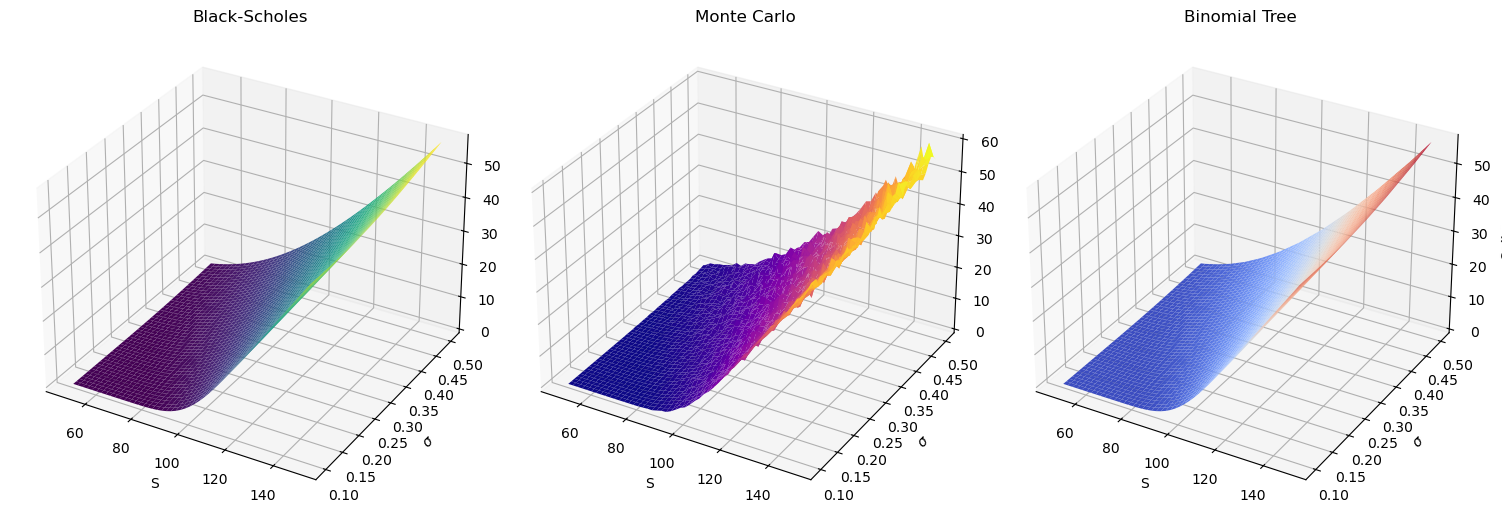

In [ ]:
S_values = np.linspace(50, 150, 50)
sigma_values = np.linspace(0.1, 0.5, 50)
S_grid, sigma_grid = np.meshgrid(S_values, sigma_values)

price_grid_bs = np.array([[black_scholes(S, K, T, r, sigma, "call") for S in S_values] for sigma in sigma_values])
price_grid_mc = np.array([[montecarlo_pricing(S, K, T, r, sigma, N, "call") for S in S_values] for sigma in sigma_values])
price_grid_bt = np.array([[binomial_tree(S, K, T, r, sigma, N=100, option_type="call", american=False) for S in S_values] for sigma in sigma_values])


fig = plt.figure(figsize=(15, 10))


# Black-Scholes 
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(S_grid, sigma_grid, price_grid_bs, cmap="viridis")
ax1.set_title("Black-Scholes")
ax1.set_xlabel("S")
ax1.set_ylabel("$\sigma$")
ax1.set_zlabel("Call Price")

# Monte Carlo 
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(S_grid, sigma_grid, price_grid_mc, cmap="plasma")
ax2.set_title("Monte Carlo")
ax2.set_xlabel("S")
ax2.set_ylabel("$\sigma$")
ax2.set_zlabel("Call Price")

# Binomial Tree 
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(S_grid, sigma_grid, price_grid_bt, cmap="coolwarm")
ax3.set_title("Binomial Tree")
ax3.set_xlabel("S")
ax3.set_ylabel("$\sigma$")
ax3.set_zlabel("Call Price")



plt.tight_layout()
plt.show()

In [70]:
print("S: ", S)
print("σ: ", sigma)

print(f"Call price (Black-Scholes): {call_price_bs:.2f}")
print(f"Call Price (Monte Carlo): {call_price_mc:.2f}")
print(f"Call price (Binomial tree): {call_price_bt:.2f}")

S:  105
σ:  0.2
Call price (Black-Scholes): 10.97
Call Price (Monte Carlo): 11.05
Call price (Binomial tree): 10.97
